# Bankruptcy Classification Project
<br>
This classification project utilizes the following dataset from kaggle: 

https://www.kaggle.com/fedesoriano/company-bankruptcy-prediction

_"The data were collected from the Taiwan Economic Journal for the years 1999 to 2009. Company bankruptcy was defined based on the business regulations of the Taiwan Stock Exchange."_

For further description of the dataset features, inspect the link above.

## Part I Exploring the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from sklearn.feature_selection import SelectKBest, SelectFromModel, f_classif
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import f1_score, accuracy_score, classification_report, plot_confusion_matrix

In [2]:
df = pd.read_csv('data.csv')

df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


**The dataset has a variety of financial ratios and elements across its 96 features. It's also worth noting that the currency is also notated in Yuan. In the financial sector there are many financial ratios out there, and many are used to evaluate the general health of a company. Below is the complete list of factors**

In [3]:
# What are the feature variables?
df.columns

Index(['Bankrupt?', ' ROA(C) before interest and depreciation before interest',
       ' ROA(A) before interest and % after tax',
       ' ROA(B) before interest and depreciation after tax',
       ' Operating Gross Margin', ' Realized Sales Gross Margin',
       ' Operating Profit Rate', ' Pre-tax net Interest Rate',
       ' After-tax net Interest Rate',
       ' Non-industry income and expenditure/revenue',
       ' Continuous interest rate (after tax)', ' Operating Expense Rate',
       ' Research and development expense rate', ' Cash flow rate',
       ' Interest-bearing debt interest rate', ' Tax rate (A)',
       ' Net Value Per Share (B)', ' Net Value Per Share (A)',
       ' Net Value Per Share (C)', ' Persistent EPS in the Last Four Seasons',
       ' Cash Flow Per Share', ' Revenue Per Share (Yuan ¥)',
       ' Operating Profit Per Share (Yuan ¥)',
       ' Per Share Net profit before tax (Yuan ¥)',
       ' Realized Sales Gross Profit Growth Rate',
       ' Operating Profit

**In exploring the data, I've picked three factors to plot the histograms for, Debt Ratio %, Cash/Total Assets, and Total Expense/Assets. At a high level, I would think these factors could explain why some companies would go bankrupt. I would expect companies that went bankrupt to have a higher debt ratio than companies that didn't. Likewise, if the company doesn't have a lot of cash on hand, if things go bad, then they won't have enough liquidity to pay off their debts, or if they spend an incur expenses at a higher proportion of their assets, it could lead to trouble down the road. Below is an inspection of these thoughts with separating the distribution of companies that went bankrupt and those that didn't by color**

<AxesSubplot:xlabel=' Total expense/Assets', ylabel='Count'>

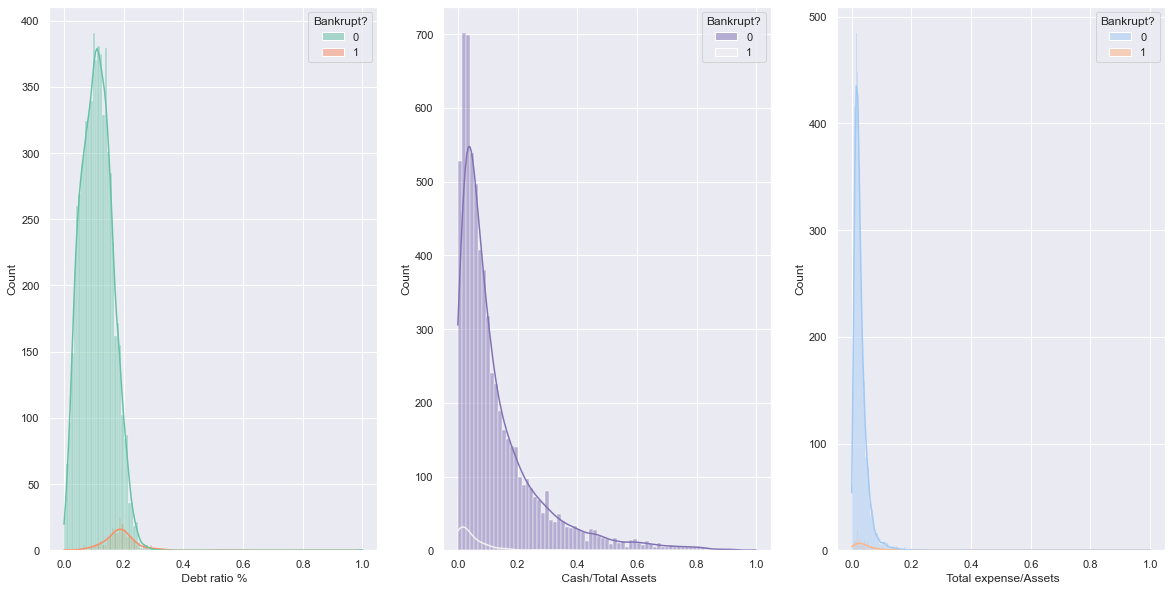

In [4]:
# Plotting selected features

fig, axs = plt.subplots(figsize=(20,10), ncols=3)
sns.histplot(data=df, x=" Debt ratio %", hue='Bankrupt?', kde=True, palette="Set2", legend=True, ax=axs[0])
sns.histplot(data=df, x=" Cash/Total Assets", hue='Bankrupt?', kde=True, palette="light:m_r", ax=axs[1])
sns.histplot(data=df, x=" Total expense/Assets", hue='Bankrupt?', kde=True, palette="pastel", ax=axs[2])

**Of the three features explored here, it looks like the Debt ratio % has the most variation in its distribution among bankrupt companies. It's worth noting the overall distribution of companies that went bankrupt vs companies that didn't are very imbalanced.**

In [5]:
# Checking dataset entries and for null values

print(len(df))
total = df.isna().sum()
sum_total = 0
for i in total:
    sum_total += i
    
print(sum_total)

6819
0


In [6]:
# Splitting into X and Y variables

X = df.drop(['Bankrupt?', ' Net Income Flag', ' Liability-Assets Flag'], axis=1)

Y = df['Bankrupt?']

In [35]:
# Displaying X variables with strong correlations

corr_matrix = X.copy()

corr_matrix = corr_matrix.corr(method="pearson")
corr_matrix = corr_matrix[corr_matrix > 0.6]
corr_matrix = corr_matrix[corr_matrix != 1]
corr_matrix = corr_matrix.dropna(axis=1, how='all')

correlated_items = []
for x in corr_matrix.columns:
    column_name = x
    for i in range(len(corr_matrix.index)):
        index_name = corr_matrix[x].index[i]
        corr = corr_matrix[x][i]
        if corr > 0:
            correlated_items.append((column_name, index_name, round(corr,4)))
        
print(len(correlated_items))

196


**The list above shows correlations between features between .6 and 1, showing there are quite a few features strongly correlated with one another. This makes sense due to the nature of calculating certain ratios and financial evaluations, which are driven off similar balance sheet values.**

<AxesSubplot:ylabel='Bankrupt?'>

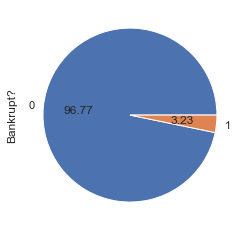

In [8]:
# Displaying Y variable distribution
Y.value_counts().plot.pie(autopct='%.2f')

**As mentioned earlier, the data here is very imbalanced, with ~97% consist of companies not going bankrupt, with only ~3% going bankrupt. To combat this for the classification modeling, two methods to do so are Randum Under Sampling and Random Over Sampling demonstrated below.**

0    220
1    220
Name: Bankrupt?, dtype: int64


<AxesSubplot:ylabel='Bankrupt?'>

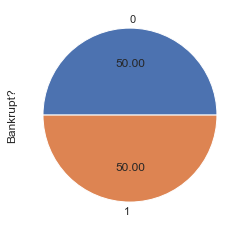

In [9]:
# Performing Random Under Sampling
rus = RandomUnderSampler(sampling_strategy=1)
X_rus, Y_rus = rus.fit_resample(X, Y)

print(Y_rus.value_counts())
Y_rus.value_counts().plot.pie(autopct='%.2f')



0    6599
1    6599
Name: Bankrupt?, dtype: int64


<AxesSubplot:ylabel='Bankrupt?'>

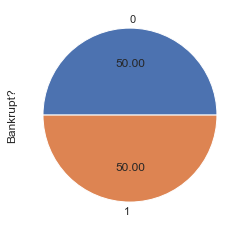

In [10]:
#Performing Random Over Sampling
ros = RandomOverSampler(sampling_strategy=1)
X_ros, Y_ros = ros.fit_resample(X, Y)

print(Y_ros.value_counts())
Y_ros.value_counts().plot.pie(autopct='%.2f')

**As you can see by the plots above, random under sampling randomly selects an amount of non bankrupt companies to equal the number of bankrupt companies in the dataset while over sampling randomly generates data to create bankrupt companies based on the 220 data entries available. With any decision such as this, there are trade-offs with selecting either method. The benefit of under sampling is the dataset is reduced to a more manageable number of data entries, but with the cost of potentially having a biased sample. Over sampling doesn't have this biased sample issue, but it could be subject to overfitting due to artificially inflating the sample of events that might not happen as often in the full population.**

**I've continued the analysis with both versions to see the difference in model performance between under and over sampling.**

In [11]:
# Scaling the datasets
scaler = MinMaxScaler()


# Random Undersample Set
cols = X_rus.columns
indx = X_rus.index

X_rus_scaled = scaler.fit_transform(X_rus)

df_rus_scaled = pd.DataFrame(X_rus_scaled, columns=cols, index=indx)
df_rus_scaled['Bankrupt?'] = Y_rus


# Random Oversample Set
cols = X_ros.columns
indx = X_ros.index

X_ros_scaled = scaler.fit_transform(X_ros)

df_ros_scaled = pd.DataFrame(X_ros_scaled, columns=cols, index=indx)
df_ros_scaled['Bankrupt?'] = Y_ros


In [12]:
# Splitting into training and testing datasets

X_rus_train, X_rus_test, Y_rus_train, Y_rus_test = train_test_split(X_rus_scaled, Y_rus, test_size=0.3, random_state=101)

X_ros_train, X_ros_test, Y_ros_train, Y_ros_test = train_test_split(X_ros_scaled, Y_ros, test_size=0.3, random_state=101)

## Part II Feature Importance and Model Designs

**Below are set up functions for various classification models and tools used below for the random under and random over datasets:**

In [13]:
# Model functions

def rand_forest(X, Y, feature_names):
    rf_model = RandomForestClassifier()
    rf_model.fit(X, Y)
    importances = rf_model.feature_importances_
    
    df_importances = pd.DataFrame({'Importance': importances, 'Variable': feature_names}).sort_values('Importance',
                                                                                                     ascending=False)
    df_importances['Cumusum'] = df_importances['Importance'].cumsum(axis=0)
    
    return df_importances, rf_model
    
def pca_function(df, components):
    pca = PCA(n_components=components)
    pca.fit(df)
    X_pca = pca.transform(df)
    
    return X_pca, pca

def knn_function(x_train, x_test, y_train, y_test):
    knn = KNeighborsClassifier()
    knn.fit(x_train, y_train)
    
    y_train_pred = knn.predict(x_train)
    y_test_pred = knn.predict(x_test)
    
    f1_train = f1_score(y_train, y_train_pred)
    f1_test = f1_score(y_test, y_test_pred)
    
    return f1_train, f1_test, knn, y_test_pred

### PCA

**I first call the pca function to graph the cumulative explained variance across all of the features for each sample group.**

In [14]:
# PCA

X_rus_pca, rus_pca = pca_function(X_rus_scaled, X_rus_scaled.shape[1])
X_ros_pca, ros_pca = pca_function(X_ros_scaled, X_rus_scaled.shape[1])

Text(0, 0.5, 'Cumulative Percent Variance Explained')

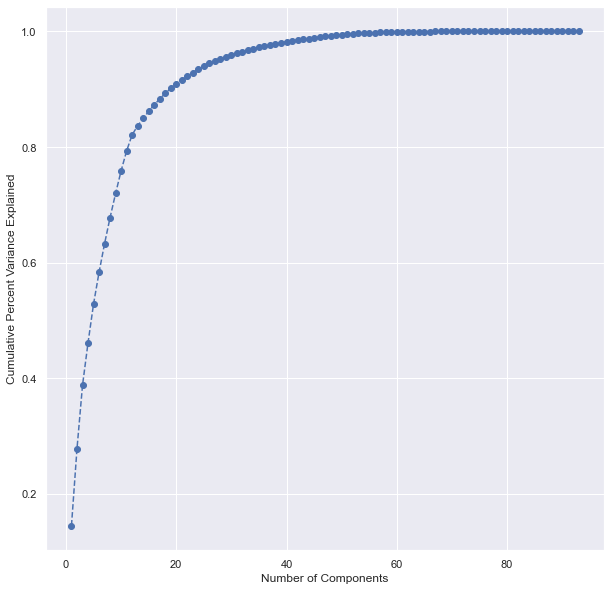

In [15]:
pca_var = rus_pca.explained_variance_ratio_.cumsum()
plt.figure(figsize=(10,10))
plt.plot(range(1,94), pca_var, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Percent Variance Explained')

Text(0, 0.5, 'Cumulative Percent Variance Explained')

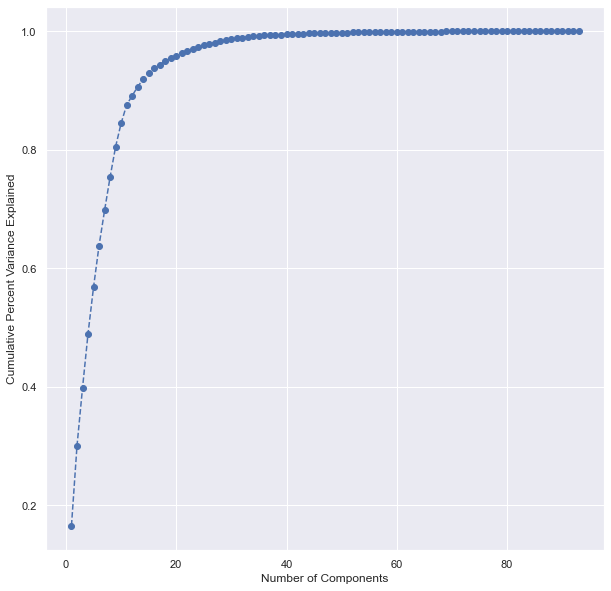

In [16]:
pca_var = ros_pca.explained_variance_ratio_.cumsum()
plt.figure(figsize=(10,10))
plt.plot(range(1,94), pca_var, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Percent Variance Explained')

**For the Random Under Sample group, the majority of the explained variance is in the first 40 components, a reduction of 53 components from the original 93 within this dataset.** 

**To test further, for each of these 40 components, I then split the feature set by the first 40 components, and obtain the f_1 scores for each train and test subset of the sliced data:**

In [17]:
# RUS 
train_f1 = []
test_f1 = []
for num in range(40):
    X_split = X_rus_pca[:, 0:num+1]
    
    X_train, X_test, Y_train, Y_test = train_test_split(X_split, Y_rus, test_size=0.2, random_state=101)
    
#     X_train = standardize(X_train, scaler)
#     X_test = standardize(X_test, scaler)
    
    f1_train, f1_test, knn, y_test_pred = knn_function(X_train, X_test, Y_train, Y_test)
    train_f1.append(f1_train)
    test_f1.append(f1_test)

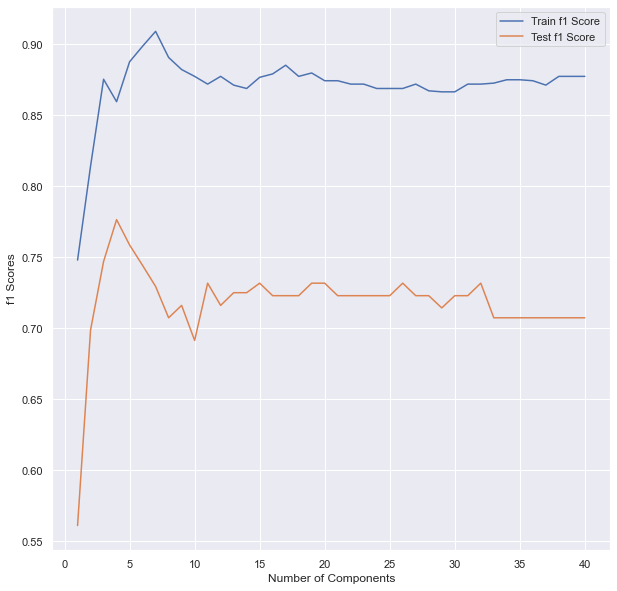

In [18]:
plt.figure(figsize=(10, 10))
plt.plot(range(1,41), train_f1, label='Train f1 Score')
plt.plot(range(1,41), test_f1, label='Test f1 Score')
plt.ylabel('f1 Scores')
plt.xlabel('Number of Components')
plt.legend()
plt.show()

**Visually, it appears the test dataset f_1 score peak is around 4 components. This is due to knn losing performance as more features are added. From this graph, the final model is selected using the first seven features.**

              precision    recall  f1-score   support

           0       0.86      0.73      0.79        49
           1       0.72      0.85      0.78        39

    accuracy                           0.78        88
   macro avg       0.79      0.79      0.78        88
weighted avg       0.80      0.78      0.78        88



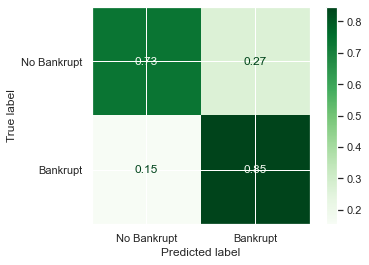

In [33]:
X_split = X_rus_pca[:, 0:4]

X_train, X_test, Y_train, Y_test = train_test_split(X_split, Y_rus, test_size=0.2, random_state=101)
    
# X_train = standardize(X_train, scaler)
# X_test = standardize(X_test, scaler)
    
f1_train, f1_test, knn, y_test_pred = knn_function(X_train, X_test, Y_train, Y_test)

print(classification_report(Y_test, y_test_pred))

plot_confusion_matrix(knn, X_test, Y_test, cmap=plt.cm.Greens,
                      display_labels=['No Bankrupt','Bankrupt'], normalize='true')

**With the random undersampling dataset, 85% instances where a company went bankrupt were correctly predicted while 73% of companies that didn't go bankrupt were correctly predicted.**

**With the random over sampling, a similar method is applied, but with only the first 20 features due to the majority of the variance being explained by fewer components initially.**

In [20]:
# ROS
train_f1 = []
test_f1 = []
for num in range(20):
    X_split = X_ros_pca[:, 0:num+1]
    
    X_train, X_test, Y_train, Y_test = train_test_split(X_split, Y_ros, test_size=0.2, random_state=101)
    
#     X_train = standardize(X_train, scaler)
#     X_test = standardize(X_test, scaler)
    
    f1_train, f1_test, knn, y_test_pred = knn_function(X_train, X_test, Y_train, Y_test)
    train_f1.append(f1_train)
    test_f1.append(f1_test)

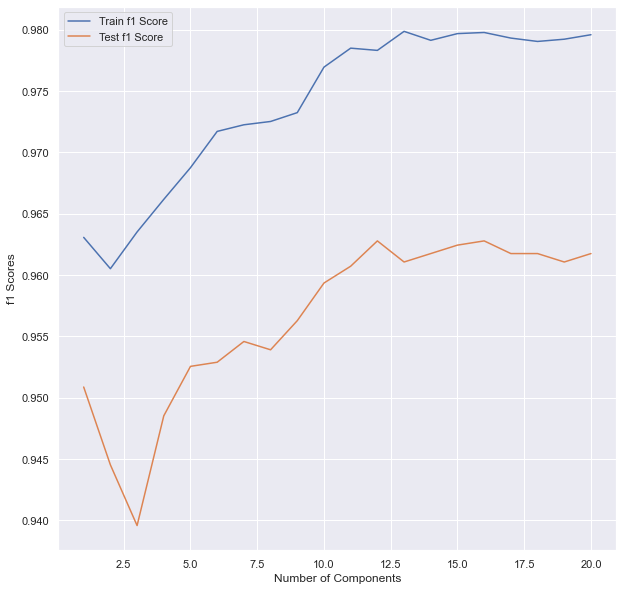

In [21]:
plt.figure(figsize=(10, 10))
plt.plot(range(1,21), train_f1, label='Train f1 Score')
plt.plot(range(1,21), test_f1, label='Test f1 Score')
plt.ylabel('f1 Scores')
plt.xlabel('Number of Components')
plt.legend()
plt.show()

**However, with the random oversampling set, the knn f_1 score for the test subset peaks around 11 components instead of 7.**

              precision    recall  f1-score   support

           0       1.00      0.92      0.96      1295
           1       0.92      1.00      0.96      1345

    accuracy                           0.96      2640
   macro avg       0.96      0.96      0.96      2640
weighted avg       0.96      0.96      0.96      2640



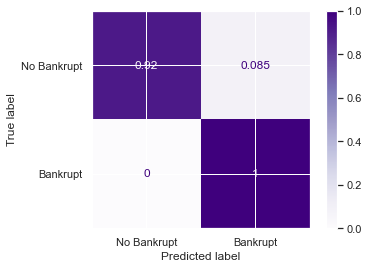

In [22]:
X_split = X_ros_pca[:, 0:11]

X_train, X_test, Y_train, Y_test = train_test_split(X_split, Y_ros, test_size=0.2, random_state=101)
    
# X_train = standardize(X_train, scaler)
# X_test = standardize(X_test, scaler)
    
f1_train, f1_test, knn, y_test_pred = knn_function(X_train, X_test, Y_train, Y_test)

print(classification_report(Y_test, y_test_pred))

plot_confusion_matrix(knn, X_test, Y_test, cmap=plt.cm.Purples,
                      display_labels=['No Bankrupt','Bankrupt'], normalize='true')

**With the random oversampling dataset, 100% instances where a company went bankrupt were correctly predicted while 92% of companies that didn't go bankrupt were correctly predicted.**

### PCA Conclusions

**PCA component analysis resulted in pretty good results for the classification prediction and reducing the bulk components within the dataset. The main limitation with PCA is the interpretation of the variables after transformation. If I were looking to invest in a company and wanting to assess the risks of bankruptcy and predict based on certain variables, I think I would want to know which features are the most important ones to look at. With PCA, the feature importance is a bit of a black box which does not necessarily prove fully useful within this data context.**

### Random Forest & Gradient Boosting

**To further examine the features and their importance when predicing the bankruptcy classification, I decided to implement the random forest**

In [23]:
# Random Forest Model and importance list

col_list = cols

rus_df_importances, rus_rf_model = rand_forest(X_rus_train, Y_rus_train, col_list)

print(rus_df_importances.head(40),'\n')


ros_df_importances, ros_rf_model = rand_forest(X_ros_train, Y_ros_train, col_list)

print(ros_df_importances.head(40))


    Importance                                           Variable   Cumusum
68    0.055532                         Total income/Total expense  0.055532
84    0.053188                         Net Income to Total Assets  0.108720
18    0.051045            Persistent EPS in the Last Four Seasons  0.159765
8     0.045626        Non-industry income and expenditure/revenue  0.205391
89    0.039748                                Liability to Equity  0.245139
22    0.036517           Per Share Net profit before tax (Yuan ¥)  0.281657
67    0.035074                  Retained Earnings to Total Assets  0.316731
39    0.033705                               Borrowing dependency  0.350436
42    0.029763              Net profit before tax/Paid-in capital  0.380198
92    0.028910                                Equity to Liability  0.409108
65    0.027035                         Current Liabilities/Equity  0.436143
37    0.026976                                   Net worth/Assets  0.463119
36    0.0259

**With both models, the first 40 features have over 80% of the cumulative importance when, but it is worth noting the variation in features that are listed and the ranking within each list of the first 40 attributes.**

In [24]:
#Creating new datasets and splits

df_rus_gb = df_rus_scaled[rus_df_importances['Variable'][:40]]

df_ros_gb = df_ros_scaled[rus_df_importances['Variable'][:40]]

X_rus_train, X_rus_test, Y_rus_train, Y_rus_test = train_test_split(X_rus_scaled, Y_rus, test_size=0.3, random_state=101)

X_ros_train, X_ros_test, Y_ros_train, Y_ros_test = train_test_split(X_ros_scaled, Y_ros, test_size=0.3, random_state=101)

**The model below implements a gradient boosting model with a randomized search of different parameters in `gb_params` to achieve the best score, that model is then fit with the testing dataset and a confusion matrix is implemented**

In [25]:
# Gradient Boosting Model and Parameter setting

gb_model = GradientBoostingClassifier()

gb_params = {'n_estimators': [100, 250, 300], 'subsample': [.85, .9, 1], 'max_depth': [2, 3, 4], 
             'min_samples_split': [2, 4, 6], 'min_samples_leaf': [1, 3, 5], 'max_features': [10, 12, 14, 20]}


# Random Search Cross Validation 
rand_model_rus = RandomizedSearchCV(gb_model, param_distributions=gb_params, n_iter=5, scoring='accuracy')

rand_model_ros = RandomizedSearchCV(gb_model, param_distributions=gb_params, n_iter=5, scoring='accuracy')

In [26]:
rand_model_rus.fit(X_rus_train, Y_rus_train)

print(rand_model_rus.best_params_)
print(rand_model_rus.best_score_)

{'subsample': 1, 'n_estimators': 100, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 20, 'max_depth': 4}
0.8833421470121628


In [27]:
rand_model_ros.fit(X_ros_train, Y_ros_train)

print(rand_model_ros.best_params_)
print(rand_model_ros.best_score_)

{'subsample': 1, 'n_estimators': 300, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': 14, 'max_depth': 3}
0.9791078665063505


In [28]:
ros_gb_model = rand_model_ros.best_estimator_


importances = ros_gb_model.feature_importances_

df_ros_importances = pd.DataFrame({'Importance': importances, 'Variable': col_list}).sort_values('Importance',
                                                                                                     ascending=False)
df_ros_importances['Cumusum'] = df_ros_importances['Importance'].cumsum(axis=0)

df_ros_importances.head()

,Importance,Variable,Cumusum
18,0.135576,Persistent EPS in the Last Four Seasons,0.135576
39,0.111874,Borrowing dependency,0.247450
68,0.070735,Total income/Total expense,0.318185
22,0.068618,Per Share Net profit before tax (Yuan ¥),0.386803
67,0.056966,Retained Earnings to Total Assets,0.443769


In [29]:
rus_gb_model = rand_model_rus.best_estimator_


importances = rus_gb_model.feature_importances_

df_rus_importances = pd.DataFrame({'Importance': importances, 'Variable': col_list}).sort_values('Importance',
                                                                                                     ascending=False)
df_rus_importances['Cumusum'] = df_rus_importances['Importance'].cumsum(axis=0)

df_rus_importances.head()

,Importance,Variable,Cumusum
68,0.097436,Total income/Total expense,0.097436
84,0.096522,Net Income to Total Assets,0.193958
8,0.090974,Non-industry income and expenditure/revenue,0.284932
92,0.057694,Equity to Liability,0.342626
42,0.057467,Net profit before tax/Paid-in capital,0.400092


              precision    recall  f1-score   support

           0       0.85      0.83      0.84        72
           1       0.80      0.82      0.81        60

    accuracy                           0.83       132
   macro avg       0.82      0.82      0.82       132
weighted avg       0.83      0.83      0.83       132



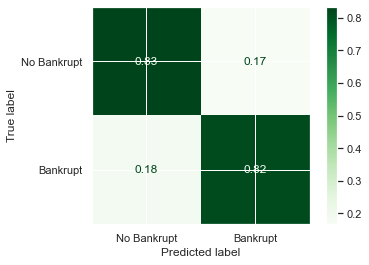

In [30]:
rus_gb_predicted = rus_gb_model.predict(X_rus_test)
rus_gb_classification = classification_report(Y_rus_test, rus_gb_predicted)

print(rus_gb_classification)
plot_confusion_matrix(rus_gb_model, X_rus_test, Y_rus_test, cmap=plt.cm.Greens,
                      display_labels=['No Bankrupt','Bankrupt'], normalize='true')

**With the random undersampling dataset, 82% instances where a company went bankrupt were correctly predicted while 83% of companies that didn't go bankrupt were correctly predicted.**

              precision    recall  f1-score   support

           0       1.00      0.95      0.98      1965
           1       0.96      1.00      0.98      1995

    accuracy                           0.98      3960
   macro avg       0.98      0.98      0.98      3960
weighted avg       0.98      0.98      0.98      3960



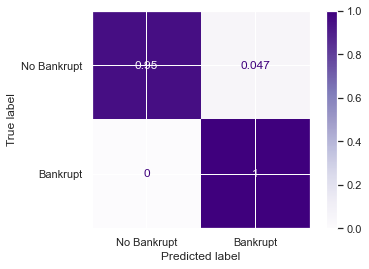

In [31]:
ros_gb_predicted = ros_gb_model.predict(X_ros_test)
ros_gb_classification = classification_report(Y_ros_test, ros_gb_predicted)

print(ros_gb_classification)
plot_confusion_matrix(ros_gb_model, X_ros_test, Y_ros_test, cmap=plt.cm.Purples,
                      display_labels=['No Bankrupt','Bankrupt'], normalize='true')

**With the random undersampling dataset, 100% instances where a company went bankrupt were correctly predicted while 95% of companies that didn't go bankrupt were correctly predicted.**

### Random Forest and Gradient Boosting Conclusions

**With the random forest and gradient boosting modeling results, this method ended up being on par with the PCA/KNN method. While the over sampling did perform better than the undersampling model, it's worth noting this model is likely to be overfit due to the sheer number of samples having to be made in order to achieve balance. The random forest model did give us some visability into which factors were important drivers for predicting bankruptcy in a company.**

#### References

**This project was a self-teaching moment for myself to continue my practice of data science. I utilized a variety of helpful instructions and resources for this classification problem that I wish to reference below.**


https://towardsdatascience.com/machine-learning-with-python-classification-complete-tutorial-d2c99dc524ec
https://365datascience.com/tutorials/python-tutorials/pca-k-means/
https://pub.towardsai.net/principal-component-analysis-pca-with-python-examples-tutorial-67a917bae9aa
https://medium.com/analytics-vidhya/implementing-pca-in-python-with-sklearn-4f757fb4429e
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
https://seaborn.pydata.org/index.html
https://www.youtube.com/watch?v=4SivdTLIwHc
https://www.analyticsvidhya.com/blog/2017/03/imbalanced-data-classification/
